<a href="https://colab.research.google.com/github/KhuramC/SoftwareTutorials/blob/main/B2_Cable_Theory_Length_Constant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cable Theory and the Length Constant
This lab will be used to introduce you to multicompartmental models and introduce you to Cable Theory illustrated by a passive dendrite.

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  !pip install neuron #installs NEURON if in google Colab

Installing neuron to simulate the dendrite and necesssary packages to plot graphs.

In [2]:
from neuron import h
import matplotlib.pyplot as plt
import numpy as np

In [3]:
h.load_file('stdrun.hoc')

1.0

# Defining dendrite geometry
The dendrite is defined here as a cylinder with given diameter and length. It is then divided into a given amount of segments that are evenly-lengthed.

In [4]:
dendrite = h.Section('dendrite') # create neuron Section hoc object
diam = 2 # micrometer
length = 10000 # micrometer
dendrite.pt3dadd(0,0,0,diam) # (x,y,z,diam) add 3d coordinate
dendrite.pt3dadd(length,0,0,diam) # (x,y,z,diam)
print("Dendrite length = " + str(dendrite.L) +  " micrometers")
print("Dendrite diameter = " + str(dendrite.diam) + " micrometers")
dendrite.nseg = 200 # number of evenly-lengthed, computational compartments per section (segments are compartments that divide up the entire section)

Dendrite length = 10000.0 micrometers
Dendrite diameter = 2.0 micrometers


# Visualization of Dendrite

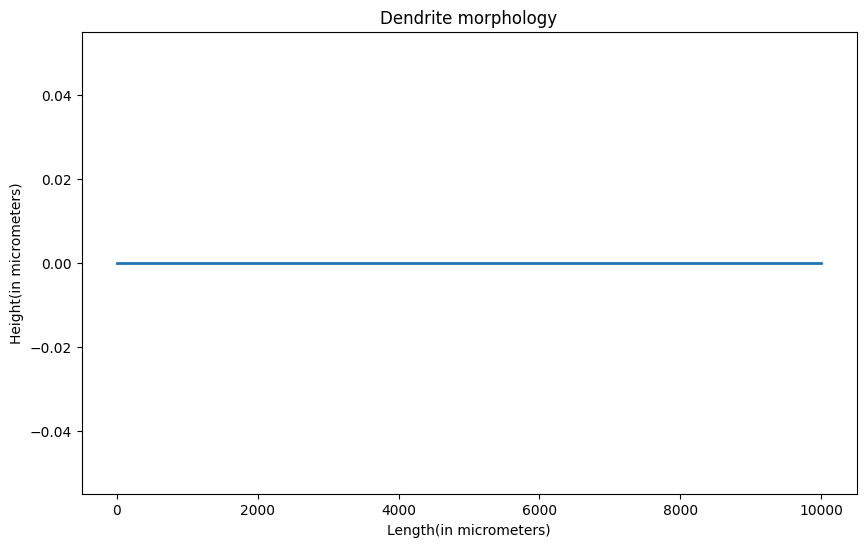

In [5]:
xcoords=[]
ycoords=[]
for i_3d in range(dendrite.n3d()): # for 3d coordinate index in range(number of 3d coordinates)
  xcoords.append(dendrite.x3d(i_3d)) # print x3d coordinate
  ycoords.append(dendrite.y3d(i_3d))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(xcoords, ycoords, linewidth= dendrite.diam)

# Add title and labels
plt.title('Dendrite morphology')
plt.xlabel('Length(in micrometers)')
plt.ylabel('Height(in micrometers)')

# Show the plot
plt.show()

# Defining Biophysics(Channels/Conductance...)
Here we add only passive leak channels, define its reversal potential and capcitance.
Anything not explicitly defined(like the leak channel conductance and axial resitivity) is defined to NEURON's default values(more on these default values and making a model can be found [here](http://web.mit.edu/neuron_v7.4/nrntuthtml/tutorial/tutA.html)).

In [6]:
# define axon membrane biophysics
dendrite.insert('pas') # passive channel

dendrite.e_pas = -70 # reveral potential mV (resting membrane potential in passive case)
dendrite.cm = 100 # membrane capacitance uF/cm2


# define leak conductance, axons are myelinated and have much less leak.
#dendrite.g_pas = (0.001) #default value for leak channel S/cm2
#dendrite.Ra = 250 # axial resistivity ohm-cm

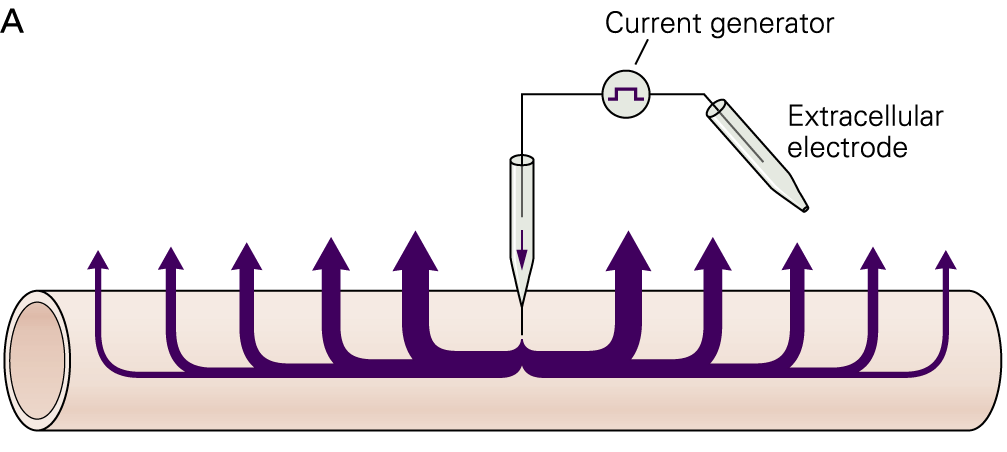
# Voltage Clamp
We want to voltage clamp the middle of the dendrite so that it spreads evenly on both sides. We will be injecting -10 mV for 1000ms.

In [7]:
# Voltage clamp halfway through the dendrite
vc = h.VClamp(dendrite(0.5)) # create hoc voltage clamp object halfway

vc.dur[0]=1000 # ms

vc.amp[0]=-10 # mV

# Simulation Parameters
Here we define the starting voltages, how long the simulation is, and do some recording of voltages throughout the simulation, and then run it.

In [8]:
# define simulation parameters
h.tstop = tstop = 1000 # how long to run the simulation in ms
h.dt = 0.025 # time step (resolution) of the simulation in ms
h.v_init = dendrite.e_pas # give v(0) = e_leak


# record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
V_vecs = [] # list of voltage vectors
i_leak_vecs = []
for seg in dendrite:
  seg_V_vec = h.Vector() # define vector object for recording variable
  seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
  V_vecs.append(seg_V_vec)

  # record leak current
  seg_i_leak_vec = h.Vector()
  seg_i_leak_vec.record(seg._ref_i_pas)
  i_leak_vecs.append(seg_i_leak_vec)

t_vec = h.Vector() # time vector
t_vec.record(h._ref_t) # record time during simulation

h.run() # run simulation

0.0

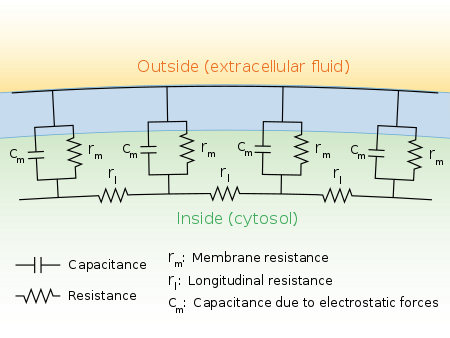

Source:[wiki.](hhttps://en.wikipedia.org/wiki/Cable_theory)
Note that the battery is not shown within this schematic and should be.


# What is Occurring through the Simulation?
As the voltage spreads out through the dendrite, it will continually leak out through the membrane(how much is dependent on the membrane resistance). However, it is important to note that there is also resistance along the dendrite, called axial resistance. However, with a constant current injection the voltage at every point approaches a steady state value, defined as some change from the resting membrane potential at that given location. This voltage is given by the following second order differential equation:
$$
τ\frac{∂V}{∂t}= λ^2\frac{∂^2V}{∂x^2}-V
$$
where τ is the time constant, λ is the length constant(more on that later) and x is the distance away from the current injection. More information can be found on this video [here.](https://www.youtube.com/watch?v=gkQtRec2464)

# Plotting Voltage Change
This graphs the steady state voltage change through injection. Notice that it is symmetrical and exponential. If you want to find out the actual voltage at that location, simply add the voltage change in that location with the resting membrane potential(which was originally defined as -70 mV).

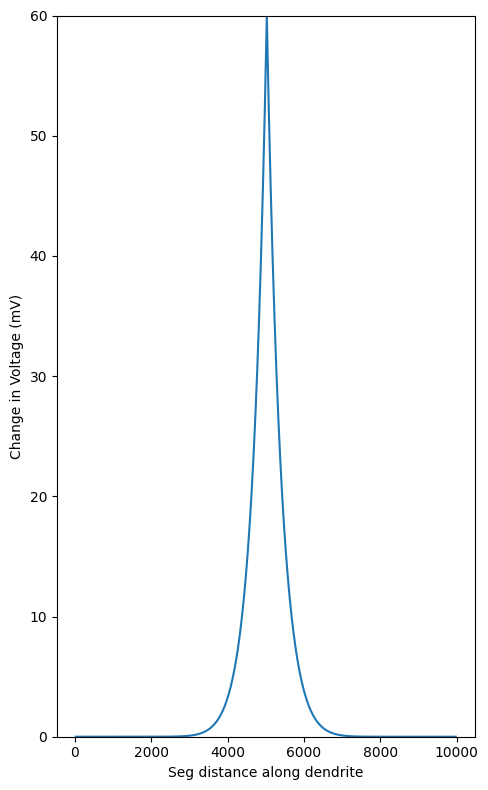

In [9]:
fig, ax = plt.subplots(figsize=(5, 8))

t = int(200/h.dt)  # time index to plot

x_values = [seg.x*dendrite.L for seg in dendrite]
y_values = [(V_vecs[i][t]-dendrite.e_pas) for i, seg in enumerate(dendrite)]

ax.plot(x_values, y_values)

ax.set_xlabel('Seg distance along dendrite')
ax.set_ylabel('Change in Voltage (mV)')
ax.set_ylim(0, vc.amp[0] - dendrite.e_pas)

plt.tight_layout()
plt.show()

# Transient Voltage Change
Here we plot the 10 most middle segments voltage throughout the simulation.

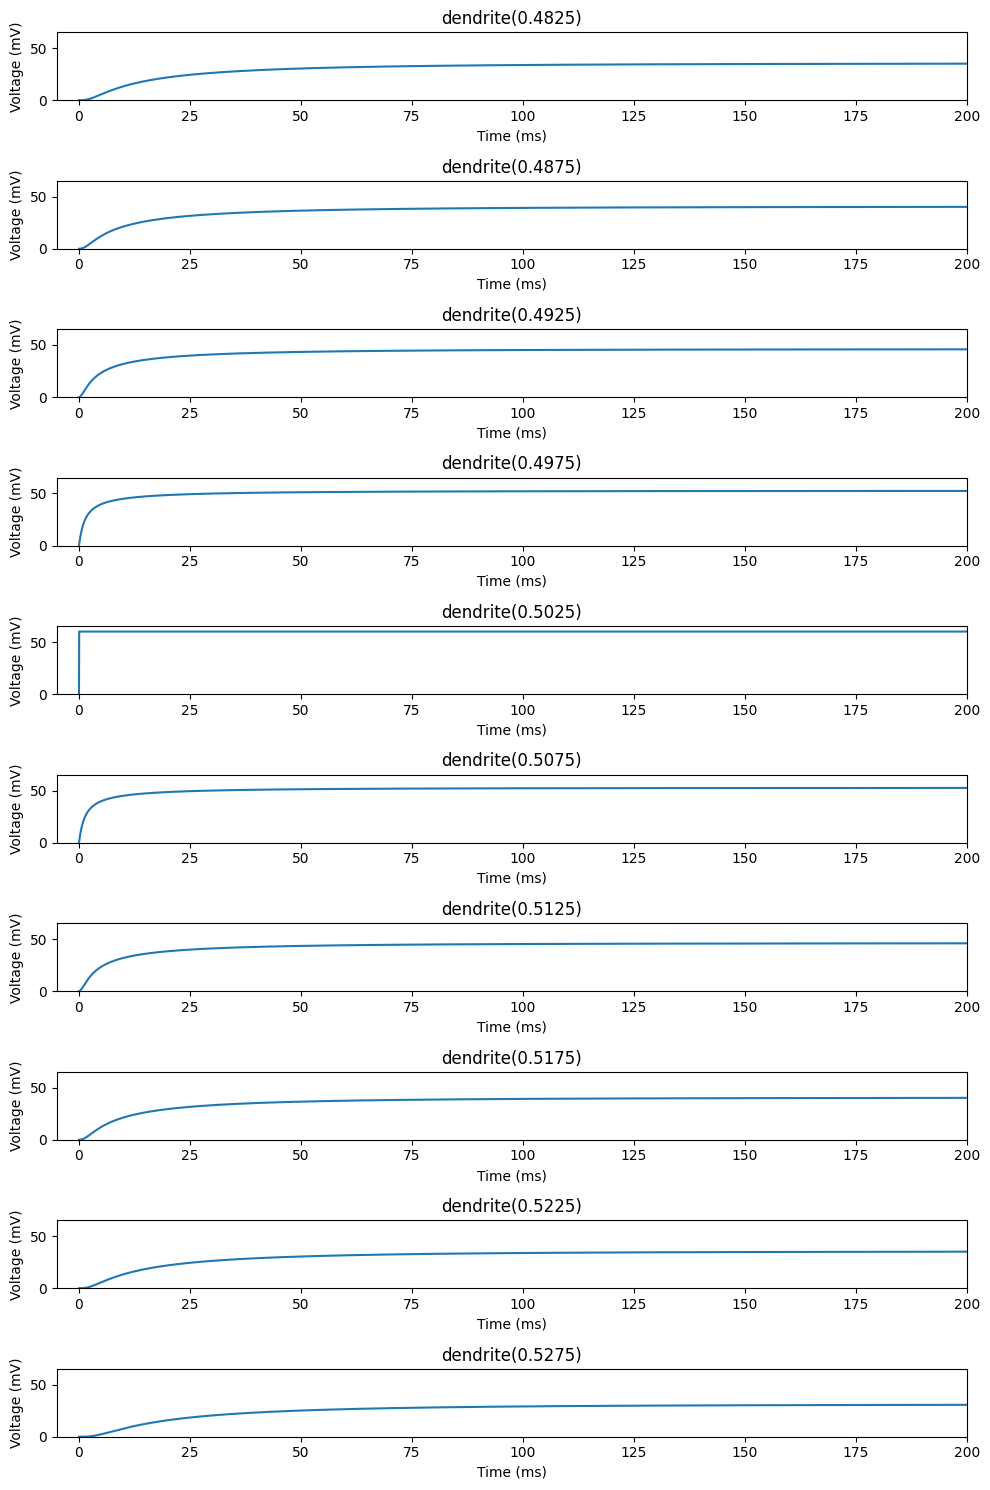

In [10]:
fig, axs = plt.subplots(10, 1, figsize=(10, 15))  # 10 subplots stacked vertically, figure size is 10x20 inches
middle_seg = dendrite.nseg / 2
#plots = (dendrite.nseg / 2) / 10
for i,seg in enumerate(dendrite):  # Assuming you have 10 segments in your axon
    if((i >= middle_seg-4) and (i <= middle_seg+5)):
      j = int(i -(middle_seg-4))
      y_values = [(V_vecs[i]-dendrite.e_pas) for i, seg in enumerate(dendrite)]
      axs[j].plot(t_vec, y_values[i])
      #axs[j].plot(t_vec, V_vecs[i])

      axs[j].set_title(seg)
      axs[j].set_xlabel('Time (ms)')
      axs[j].set_ylabel('Voltage (mV)')
      #axs[j].set_ylim(-70,vc.amp[0]+1)
      #axs[j].set_ylim(-70)
      axs[j].set_ylim(0,vc.amp[0] - dendrite.e_pas + 5)
      axs[j].set_xlim(-5,)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# Question
Why do the the surrounding segments slowly take more and more time to get to their steady state value?

# Plotting Leak Current
This graphs the leak current at every distance. The curve shown is of a very similar shape to the one of voltage change. However much current leaks out is dependent on the voltage at that location. As the voltage decreases, the leak current also would decrease.

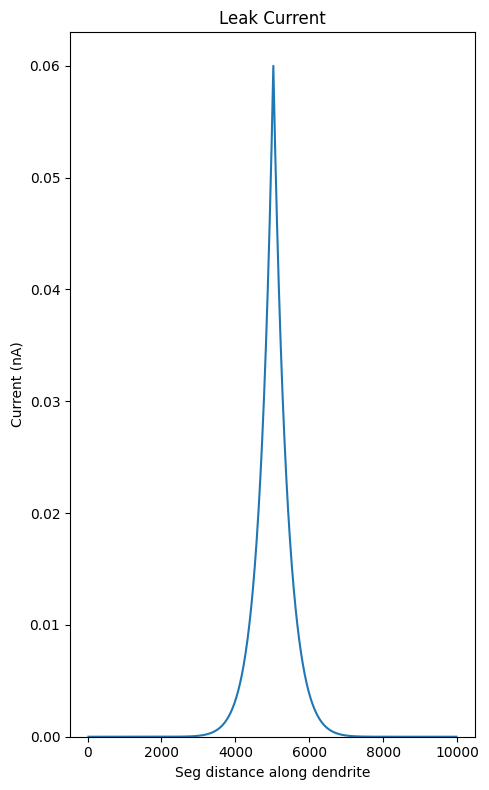

In [11]:

fig, ax = plt.subplots(figsize=(5, 8))

t = int(200/h.dt)  # time index to plot

x_values = [seg.x*dendrite.L for seg in dendrite]
y_values = [i_leak_vecs[i][t] for i, seg in enumerate(dendrite)]

ax.plot(x_values, y_values)

ax.set_xlabel('Seg distance along dendrite')
ax.set_ylabel('Current (nA)')
ax.set_ylim(0)
ax.set_title('Leak Current')

plt.tight_layout()
plt.show()

In [12]:
#rate = 25
#times = int(100/rate)
#fig, ax = plt.subplots(times,figsize=(10, 16))

#t = int(200/h.dt)  # time index to plot
#for i in range(times):
#  t = int(rate*i / h.dt)
#  x_values = [seg.x*dendrite.L for seg in dendrite]
#  y_values = [(i_leak_vecs[i][t]) for i, seg in enumerate(dendrite)]
#  print(i_leak_vecs[150][t])
#  ax[i].plot(x_values, y_values)
#  ax[i].set_xlabel(f'Seg distance along dendrite at {rate*i} ms')
#  ax[i].set_ylabel(f'Leak Current (nA) at {rate*i} ms')
#  ax[i].set_ylim(0)
  #ax[i].set_ylim(0, vc.amp[0] - dendrite.e_pas)

#plt.tight_layout()
#plt.show()

# Plotting Axial Current
Charge flows from a point of higher voltage to a point of lower voltage.

Axial Current can be computed from the center of one compartment to the center of another using ohm's law: the difference in voltage divided by the combined half segment axial resistance

Half segment axial resistance is: .01sec.Ra(L/2/sec.nseg)/(PI*(seg.diam/2)^2) or:
$$
 = \frac{0.01p_l}{π*a^2} *\frac{L}{2seg_n}
$$
where L is the length of the dendrite, seg_n is the number of segments, and pl is the cytoplasmic resistivity of the dendrite segment.
We can then compute the current from segment to segment during time t.

Notice that the graph is also exponential in nature, for the same reasons that the other graphs were.

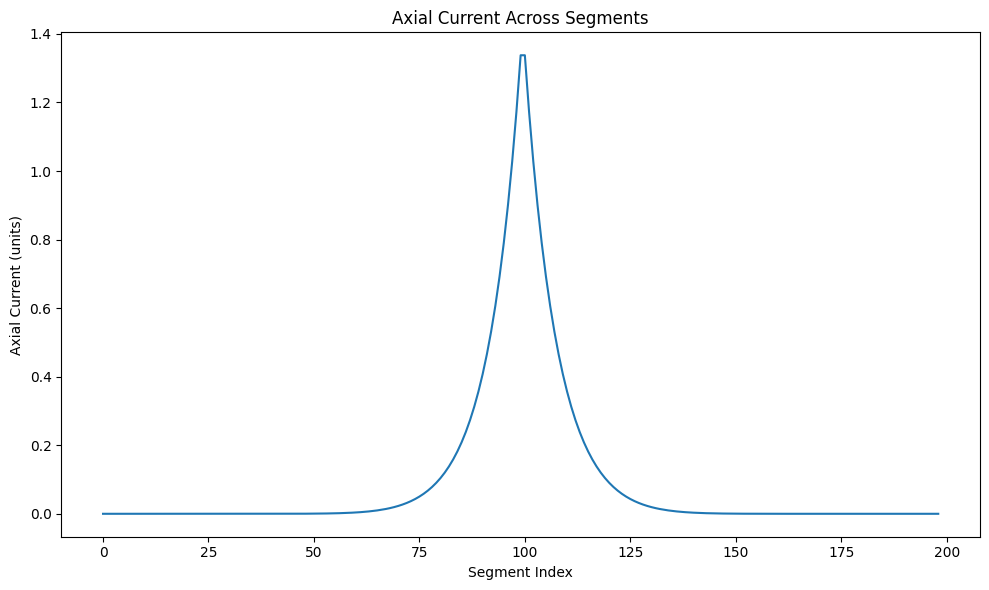

In [13]:
half_seg_Ras = [.01 * dendrite.Ra * (dendrite.L / 2 / dendrite.nseg) / (np.pi * (seg.diam / 2)**2) for seg in dendrite]
axial_I_values = []  # To store axial currents for plotting

for i, seg in enumerate(dendrite):
    if i+1 != dendrite.nseg:
        this_seg_V = V_vecs[i][t]
        next_seg_V = V_vecs[i+1][t]
        this_half_seg_Ra = half_seg_Ras[i]
        next_half_seg_Ra = half_seg_Ras[i+1]
        axial_I = (this_seg_V - next_seg_V) / (this_half_seg_Ra + next_half_seg_Ra)
        if(i < dendrite.nseg/2):
          axial_I = axial_I * -1  #this needs to be done because we computed axial current going from right to left. But from the left half, it's going left ro right.
        axial_I_values.append(axial_I) # So we want the opposite/negative of what we just computed

# Now, plot the axial currents
fig, ax = plt.subplots(figsize=(10, 6))
segment_indices = range(len(axial_I_values))  # x-values for plot, assuming one value per segment
ax.plot(segment_indices, axial_I_values)
ax.set_xlabel('Segment Index')
ax.set_ylabel('Axial Current (units)')
ax.set_title('Axial Current Across Segments')

plt.tight_layout()
plt.show()

# Length Constant

The length constant is defined as the electrotonic distance in which the voltage change is 37%(1/e) of voltage at the place of injection(which is almost always just the highest voltage change). The higher the length constant, the more voltage spreads out through the dendrite. The lower the length constant, the more voltage leaks out. More on the length constant can be found [here.](https://en.wikipedia.org/wiki/Length_constant)


# Calculating Length Constant: 2 methods

#1. Analytically
Using the definition of the length constant:

$$
\lambda = \sqrt(\frac{r_m}{r_l})
$$

Length constant = unit membrane resistance / unit axial resistance
in ohms / m.


$$
r_m = \frac{R_m}{2a\pi}
$$
Where Rm is the membrane resistance of unit area(in ohm * m^2), and a is the radius of the of the dendrite(in m).

In [14]:
# calculate length constant from membrane resistance and axial resistance
Rm = 1/dendrite.g_pas # ohm / cm^2
Rm_in_m = Rm / 10000 # convert to ohm / m^2
radius_in_m = (dendrite.diam / 2) / 1000000 # convert um to m
rm = Rm_in_m / (2 * np.pi * radius_in_m) # rm = Rm / (2 * pi * radius) # ohm * m

$$
r_l = \frac{p_l}{a^2π}
$$
Where a is the radius of the dendrite(in m) and pl is the resitivity of the internal cytoplasm(in ohm * m).

In [15]:
Ra_in_m = dendrite.Ra / 100 # convert ohm-cm to ohm-m
ra = Ra_in_m / (np.pi * (radius_in_m)**2) #ra = Ra / (pi * radius^2) # ohm / m
length_constant = np.sqrt(rm / ra) #plug into the formula
length_constant = round(length_constant,4)
print("Lambda = " + str(length_constant) + " m") #in meters

Lambda = 0.0004 m


# Interesting Notes:
Through these equations, we can see that the length constant increases as the membrane resistance increases. This makes sense as the membrane is less 'leaky', so more voltage travels in the axial direction. On the other hand, the length constant decreases as the axial resistance increases. This also makes sense as more voltage is lost while traveling in the axial direction. How does the diameter of the dendrite contribute? Substituting the equations in gets us this new formula for λ:
$$
λ = \sqrt\frac{aR_m}{2p_l}
$$
As we can see, increasing the diameter also increases the length constant. The diameter makes it easier to travel down the axial direction more than it makes easier for the voltage to leak out.

#2.Experimentally
We can also find the length constant using the simulation's values for voltage solving for the distance away from the site of current injection(the center of the dendrite).

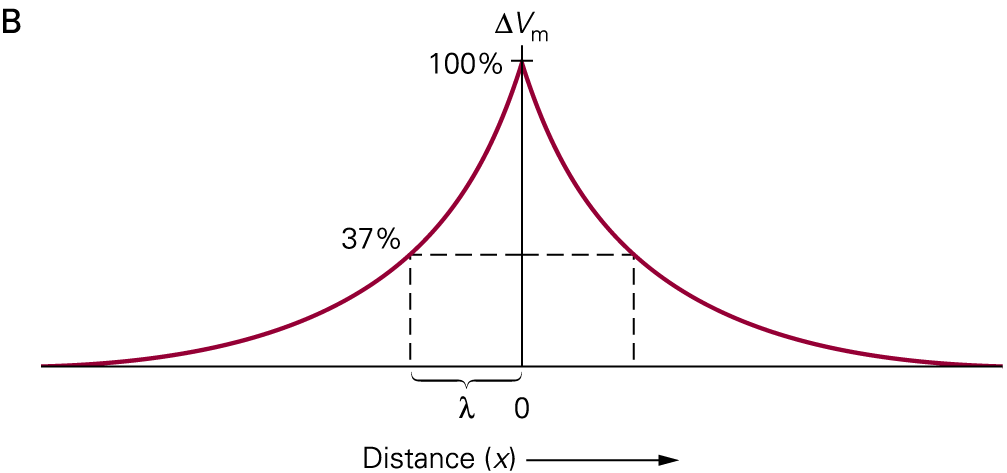

Length constant is where 63% of the voltage change has occurred(or the voltage change is 37% of the voltage change in the middle), so we can just find the voltage(the y value) and then solve to find distance(the x value) away from the center it is, which is the length constant.

In [16]:
import math
V0 = vc.amp[0] #max is where we are putting in the current, i.e. -10mV
Vsteady = dendrite.e_pas #the steady is when there is no current leaking, i.e. -70mV, or the resting membrane potential.
deltav = V0 - Vsteady #the change in V is the difference between the two, i.e. 60 mV
dv = deltav /math.e # 37% of the change
Vx = Vsteady + dv # add to get where we are at 37% of the
#print(Vx)
distance = 0
diffray = []
for i in range(len(V_vecs)):                #this goes over every segment to find out where the voltage is closest to the Vx we want
  diffray.append(abs(Vx - max(V_vecs[i])))
minindex = diffray.index(min(diffray))

for i,seg in enumerate(dendrite):
  if(i == minindex):
    #print(f"maximum V at {seg} ({seg.x*dendrite.L} away from 0):{max(V_vecs[i])} mv")
    distance = seg.x*dendrite.L
#the length_constant is the distance between the Vx and the middle of the axon(where the current is being injected), so we need account for that
length_constant = abs(distance - (dendrite.L/2))
#rounding + converting from micrometers to meters.
length_constant_in_m = length_constant/(10**6)
#then going back to millimeters and rounding
print("Lambda  = " + str(round(length_constant_in_m, 4)) + " m")

Lambda  = 0.0004 m


Even though NEURON technically codes for the length constant slightly differently, the difference is not large enough, and decreases as the length of the dendrite increases. For more information on the differences, look [here.](https://nrn.readthedocs.io/en/latest/courses/electrotonic_analysis.html)

# Questions
1. Decrease the diameter of the dendrite and rerun the simulation. How do you think lambda changes? Does the calculation support your theory?
2. Increase the cytoplasmic resistivity and rerun the simulation. How do you think lambda changes? Does the calculation support your theory?

# Why Does This Matter?
The length constant is very important to concepts relating to AP(action potential) propagation down an axon. If an action potential is generated in the soma and is propagated down an axon, electrotonic analysis with the length constant is necessary to see if the voltage will actually travel to the end. If the length constant is too small, then it can't travel to the end of the axon to communicated with other neurons. The length constant is as fundamental as the time constant for electrotonic distance.
